### <font color='red'> Includes and network parameters</font>

In [1]:
import time
import shutil
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt



In [2]:
#conda install pytorch torchvision torchaudio -c pytorch

In [108]:
# Network parameters
'''
num_neurons : TYPE list
            DESCRIPTION. list of neurons in each layer.
                This should have a minimum length of 3. 
                First element represents the dimension of input vector.
                Last element represents the dimension of the output vector.
                middle elements represent the number of neurons in hidden layers.
activations : TYPE, option list where each element can be either 'relu' or 'sigmoid' or 'tanh'
            DESCRIPTION. The default is ['relu'].
            If len(activations)==1: 
                same activation function is applied across all hidden layers.
            else:
                len(activations) should be equal to the number of hidden layers.
'''
num_neurons = [2,20,10,10,2] # list of neurons in each layer of NN. 
activations = ['relu'] # represents the activation function used at the hidden layers.

# optimizer parameters
lr = 0.01
lr_step = [500]
weight_decay = 1e-3

#  training parameters
num_epochs = 200
batch_size = 256

# 
print_freq = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### <font color='red'>Create and plot data set</font>

Do not change this cell!

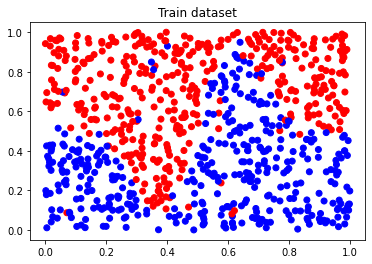

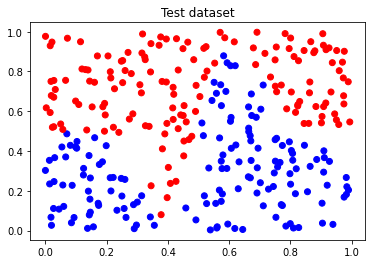

In [4]:
# DO NOT change this cell.
ns = 800
np.random.seed(0)
X_train = np.random.rand(ns,2)
x1 = X_train[:,0]
x2 = X_train[:,1]
y_train = ((np.exp(-((x1-0.5)*6)**2)*2*((x1-0.5)*6)+1)/2-x2)>0 

idx = np.random.choice(range(ns),size=(int(ns*0.03),))
y_train[idx] = ~y_train[idx]

ns = 300
np.random.seed(1)
X_val = np.random.rand(ns,2)
x1 = X_val[:,0]
x2 = X_val[:,1]
y_val = ((np.exp(-((x1-0.5)*6)**2)*2*((x1-0.5)*6)+1)/2-x2)>0 

def plot(X,y,title="Dataset"):
    colors = np.where(y==0, 'r', 'b')
    plt.figure()
    plt.scatter(X[:,0],X[:,1],color=colors)
    plt.title(title)
    plt.show()

plot(X_train,y_train,"Train dataset")
plot(X_val,y_val,"Test dataset")

### <font color='red'>Load data set into Torch dataloader</font>

In [5]:
X_train_tensor = torch.Tensor(X_train) # transform to torch tensor
y_train_tensor = torch.Tensor(y_train)

train_dataset = TensorDataset(X_train_tensor,y_train_tensor) # create your datset
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,drop_last=False)

X_val_tensor = torch.Tensor(X_val) # transform to torch tensor
y_val_tensor = torch.Tensor(y_val)

val_dataset = TensorDataset(X_val_tensor,y_val_tensor) # create your datset
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True,drop_last=False)

In [6]:
X_train_tensor

tensor([[0.5488, 0.7152],
        [0.6028, 0.5449],
        [0.4237, 0.6459],
        ...,
        [0.0988, 0.7486],
        [0.4527, 0.7137],
        [0.9154, 0.1466]])

### <font color='red'>Model: Feedforward neural network</font>

In [7]:
class LinearNN(nn.Module):
    
    def __init__(self,num_neurons,activations=['relu']):
        '''
        Parameters
        ----------
        num_neurons : TYPE list
            DESCRIPTION. list of neurons in each layer.
                This should have a minimum length of 3. 
                First element represents the dimension of input vector.
                Last element represents the dimension of the output vector.
                middle elements represent the number of neurons in hidden layers.
            
        activations : TYPE, optional list.
            DESCRIPTION. The default is ['relu'].
            If len(activations)==1: 
                same activation function is applied across all hidden layers.
            else:
                len(actiavtions) should be equal to the number of hidden layers.

        Returns
        -------
        None.

        '''
        
        super(LinearNN,self).__init__()
        assert isinstance(num_neurons,list)
        assert np.all([isinstance(neurons,int) for neurons in num_neurons])
        assert np.all([neurons>=1 for neurons in num_neurons])
        assert len(num_neurons)>=3 
        if activations is not None:
            assert isinstance(activations,(list))
            assert (len(activations)==len(num_neurons)-2) or (len(activations)==1)
        
        
        def activation_layer(act_func):
            '''
            

            Parameters
            ----------
            act_func : TYPE should be one from {'relu','sigmoid','tanh'}.
                DESCRIPTION.

            Raises
            ------
            NotImplementedError
                DESCRIPTION.

            Returns
            -------
            TYPE
                DESCRIPTION.

            '''
            if act_func=='relu':
                return nn.ReLU(inplace=True)
            elif act_func=='sigmoid':
                return nn.Sigmoid()
            elif act_func=='tanh':
                return nn.Tanh()
            else:
                raise NotImplementedError
                
        
        layers = []
        for idx,_ in enumerate(num_neurons[:-1]):
            layers.append(nn.Linear(in_features=num_neurons[idx],
                                    out_features=num_neurons[idx+1],
                                    bias=True))
            
            if idx!=len(num_neurons)-2: # add activation for all layers except the last layer.
                if len(activations)==1:
                    layers.append(activation_layer(activations[0]))
                else:
                    layers.append(activation_layer(activations[idx]))
                
        self.network = nn.Sequential(*layers)
            
    
    def forward(self,x):
        x = self.network(x)
        return x

    
def linear_nn(num_neurons,activations=['relu']):
    model = LinearNN(num_neurons,activations)
    return model


### <font color='red'>Define training function</font>

In [8]:
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        target = target.to(device)
        input_var = torch.autograd.Variable(input).to(device)
        target_var = torch.autograd.Variable(target).to(device)
        # target_var = torch.squeeze(target_var)
        # compute output
        output = model(input_var)
        
        # compute loss
        loss = criterion(output, target_var.long())

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)
        losses.update(loss.item(), input.size(0))
        top1.update(prec1[0][0], input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            curr_lr = optimizer.param_groups[0]['lr']
            print('Epoch: [{0}/{1}][{2}/{3}]\t'
                  'LR: {4}\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Train Acc {top1.val:.3f} ({top1.avg:.3f})'.format(
                   epoch, num_epochs, i, len(train_loader), curr_lr,
                   loss=losses, top1=top1))


    print(' * Train Acc {top1.avg:.3f}'.format(top1=top1))

### <font color='red'>Define validation and prediction functions</a>

In [9]:
def validate(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        target = target.to(device)
        input_var = torch.autograd.Variable(input, volatile=True).to(device)
        target_var = torch.autograd.Variable(target, volatile=True).to(device)

        # compute output
        output = model(input_var)
        # loss = criterion(output, target_var[:,None])
        loss = criterion(output, target_var.long())
        
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)
        losses.update(loss.item(), input.size(0))
        top1.update(prec1[0][0], input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Test: [{0}/{1}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                   i, len(val_loader), loss=losses,
                   top1=top1))


    print(' * Test Acc {top1.avg:.3f}'.format(top1=top1))

    return top1.avg

def predict(dataloader,model):
    y_pred = []
    y_true = []
    x = []
    with torch.no_grad():
        for i, (input, target) in enumerate(dataloader):
            # target = target.to(device)
            input_var = torch.autograd.Variable(input, volatile=True).to(device)
            # target_var = torch.autograd.Variable(target, volatile=True).to(device)
    
            # compute output
            output = model(input_var)
            labels = torch.argmax(output,axis=1)
            y_pred.extend(list(labels.data.detach().cpu().numpy()))
            y_true.extend(list(target.numpy()))
            x.extend(list(input_var.data.detach().cpu().numpy()))
    return np.array(x),np.array(y_true),np.array(y_pred)



### <font color='red'>Function to plot the decision boundary of the neural network</font>

In [10]:
def plot_decision_boundary(model):
    h = 0.005
    x_min, x_max = 0,1
    y_min, y_max = 0,1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    x1 = xx.ravel()
    x2 = yy.ravel()
    y = ((np.exp(-((x1-0.5)*6)**2)*2*((x1-0.5)*6)+1)/2-x2)>0 
    
    X_train_tensor = torch.Tensor(np.c_[xx.ravel(), yy.ravel()]) # transform to torch tensor
    y_train_tensor = torch.Tensor(y)
    
    dataset = TensorDataset(X_train_tensor,y_train_tensor) # create your datset
    dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=False,drop_last=False)

    
    x,y_true,y_pred = predict(dataloader,model)
    Z = y_pred.reshape(xx.shape)
    plt.figure()
    plt.contourf(x[:,0].reshape(xx.shape), x[:,1].reshape(xx.shape), Z, cmap=plt.cm.Paired)
    plt.axis('tight')
    
    # scatter plot of data points with colors corresponding to the correct labels. 
    ns = 500
    np.random.seed(0)
    X_test = np.random.rand(ns,2)
    x1 = X_test[:,0]
    x2 = X_test[:,1]
    y_test = ((np.exp(-((x1-0.5)*6)**2)*2*((x1-0.5)*6)+1)/2-x2)>0 
    colors = np.where(y_test==0, 'r', 'b')
    plt.scatter(x1,x2,color=colors)
    # plt.scatter(x[:,0],x[:,1],colors=)
    plt.show()

### <font color='red'>Functions to track the model performance and save the desired model state</font>

In [11]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

### <font color='red'>Create model instance; define loss function and optimizer</font> 

In [12]:
torch.manual_seed(999)
model = linear_nn(num_neurons,activations).to(device)

# define loss function (criterion) and optimizer
# criterion = nn.BCEWithLogitsLoss().to(device) 
criterion = nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
    

### <font color='red'>Train model and validate</font>

Epoch: [0/200][0/4]	LR: 0.01	Loss 0.6895 (0.6895)	Train Acc 57.031 (57.031)
 * Train Acc 51.000
Test: [0/2]	Loss 0.6871 (0.6871)	Prec@1 49.219 (49.219)
 * Test Acc 50.000
-----------------------------------------------


<ipython-input-9-56ce71016660>:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_var = torch.autograd.Variable(input, volatile=True).to(device)
<ipython-input-9-56ce71016660>:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  target_var = torch.autograd.Variable(target, volatile=True).to(device)
<ipython-input-9-56ce71016660>:48: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_var = torch.autograd.Variable(input, volatile=True).to(device)


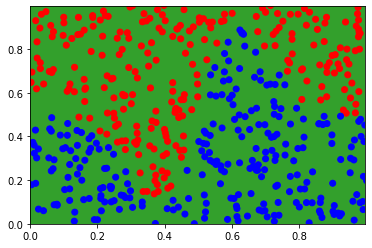

Epoch: [1/200][0/4]	LR: 0.01	Loss 0.6881 (0.6881)	Train Acc 48.828 (48.828)
 * Train Acc 65.000
Test: [0/2]	Loss 0.6783 (0.6783)	Prec@1 65.234 (65.234)
 * Test Acc 67.333
-----------------------------------------------
Epoch: [2/200][0/4]	LR: 0.01	Loss 0.6792 (0.6792)	Train Acc 64.453 (64.453)
 * Train Acc 70.625
Test: [0/2]	Loss 0.6581 (0.6581)	Prec@1 81.250 (81.250)
 * Test Acc 81.000
-----------------------------------------------
Epoch: [3/200][0/4]	LR: 0.01	Loss 0.6617 (0.6617)	Train Acc 78.906 (78.906)
 * Train Acc 75.625
Test: [0/2]	Loss 0.6222 (0.6222)	Prec@1 71.094 (71.094)
 * Test Acc 70.333
-----------------------------------------------
Epoch: [4/200][0/4]	LR: 0.01	Loss 0.6265 (0.6265)	Train Acc 69.141 (69.141)
 * Train Acc 69.500
Test: [0/2]	Loss 0.5798 (0.5798)	Prec@1 73.828 (73.828)
 * Test Acc 74.667
-----------------------------------------------
Epoch: [5/200][0/4]	LR: 0.01	Loss 0.5918 (0.5918)	Train Acc 73.438 (73.438)
 * Train Acc 75.625
Test: [0/2]	Loss 0.5192 (0.5

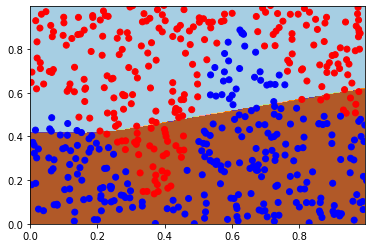

Epoch: [11/200][0/4]	LR: 0.01	Loss 0.3666 (0.3666)	Train Acc 85.156 (85.156)
 * Train Acc 82.000
Test: [0/2]	Loss 0.3594 (0.3594)	Prec@1 84.375 (84.375)
 * Test Acc 85.000
-----------------------------------------------
Epoch: [12/200][0/4]	LR: 0.01	Loss 0.4055 (0.4055)	Train Acc 83.594 (83.594)
 * Train Acc 82.375
Test: [0/2]	Loss 0.3608 (0.3608)	Prec@1 85.547 (85.547)
 * Test Acc 86.000
-----------------------------------------------
Epoch: [13/200][0/4]	LR: 0.01	Loss 0.4150 (0.4150)	Train Acc 81.641 (81.641)
 * Train Acc 82.375
Test: [0/2]	Loss 0.3427 (0.3427)	Prec@1 87.109 (87.109)
 * Test Acc 87.000
-----------------------------------------------
Epoch: [14/200][0/4]	LR: 0.01	Loss 0.4777 (0.4777)	Train Acc 80.469 (80.469)
 * Train Acc 82.625
Test: [0/2]	Loss 0.3423 (0.3423)	Prec@1 87.891 (87.891)
 * Test Acc 87.667
-----------------------------------------------
Epoch: [15/200][0/4]	LR: 0.01	Loss 0.3932 (0.3932)	Train Acc 85.547 (85.547)
 * Train Acc 83.250
Test: [0/2]	Loss 0.3327

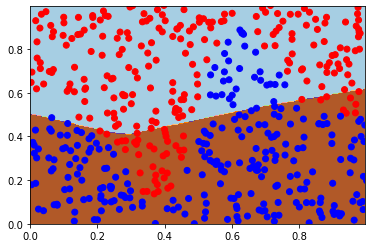

Epoch: [21/200][0/4]	LR: 0.01	Loss 0.3935 (0.3935)	Train Acc 84.375 (84.375)
 * Train Acc 83.375
Test: [0/2]	Loss 0.3559 (0.3559)	Prec@1 86.328 (86.328)
 * Test Acc 87.000
-----------------------------------------------
Epoch: [22/200][0/4]	LR: 0.01	Loss 0.4117 (0.4117)	Train Acc 82.812 (82.812)
 * Train Acc 83.500
Test: [0/2]	Loss 0.3352 (0.3352)	Prec@1 87.500 (87.500)
 * Test Acc 87.000
-----------------------------------------------
Epoch: [23/200][0/4]	LR: 0.01	Loss 0.3943 (0.3943)	Train Acc 82.812 (82.812)
 * Train Acc 83.500
Test: [0/2]	Loss 0.3619 (0.3619)	Prec@1 87.109 (87.109)
 * Test Acc 87.000
-----------------------------------------------
Epoch: [24/200][0/4]	LR: 0.01	Loss 0.3675 (0.3675)	Train Acc 84.375 (84.375)
 * Train Acc 82.250
Test: [0/2]	Loss 0.3556 (0.3556)	Prec@1 83.984 (83.984)
 * Test Acc 85.000
-----------------------------------------------
Epoch: [25/200][0/4]	LR: 0.01	Loss 0.3583 (0.3583)	Train Acc 86.719 (86.719)
 * Train Acc 82.125
Test: [0/2]	Loss 0.3720

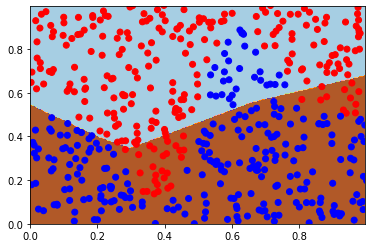

Epoch: [31/200][0/4]	LR: 0.01	Loss 0.4063 (0.4063)	Train Acc 83.594 (83.594)
 * Train Acc 84.875
Test: [0/2]	Loss 0.3167 (0.3167)	Prec@1 85.156 (85.156)
 * Test Acc 85.000
-----------------------------------------------
Epoch: [32/200][0/4]	LR: 0.01	Loss 0.3423 (0.3423)	Train Acc 85.938 (85.938)
 * Train Acc 84.750
Test: [0/2]	Loss 0.3516 (0.3516)	Prec@1 83.203 (83.203)
 * Test Acc 85.333
-----------------------------------------------
Epoch: [33/200][0/4]	LR: 0.01	Loss 0.3492 (0.3492)	Train Acc 87.109 (87.109)
 * Train Acc 84.375
Test: [0/2]	Loss 0.3334 (0.3334)	Prec@1 86.328 (86.328)
 * Test Acc 86.667
-----------------------------------------------
Epoch: [34/200][0/4]	LR: 0.01	Loss 0.3765 (0.3765)	Train Acc 84.766 (84.766)
 * Train Acc 84.250
Test: [0/2]	Loss 0.3031 (0.3031)	Prec@1 85.547 (85.547)
 * Test Acc 84.000
-----------------------------------------------
Epoch: [35/200][0/4]	LR: 0.01	Loss 0.3671 (0.3671)	Train Acc 84.766 (84.766)
 * Train Acc 83.125
Test: [0/2]	Loss 0.3198

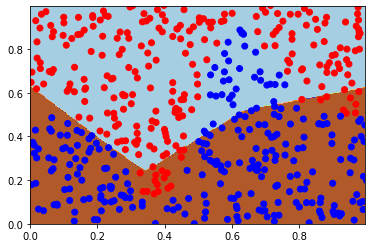

Epoch: [41/200][0/4]	LR: 0.01	Loss 0.3191 (0.3191)	Train Acc 85.938 (85.938)
 * Train Acc 83.750
Test: [0/2]	Loss 0.3255 (0.3255)	Prec@1 83.594 (83.594)
 * Test Acc 84.667
-----------------------------------------------
Epoch: [42/200][0/4]	LR: 0.01	Loss 0.3021 (0.3021)	Train Acc 87.891 (87.891)
 * Train Acc 86.625
Test: [0/2]	Loss 0.3026 (0.3026)	Prec@1 90.234 (90.234)
 * Test Acc 88.667
-----------------------------------------------
Epoch: [43/200][0/4]	LR: 0.01	Loss 0.3739 (0.3739)	Train Acc 85.156 (85.156)
 * Train Acc 85.625
Test: [0/2]	Loss 0.3147 (0.3147)	Prec@1 85.156 (85.156)
 * Test Acc 83.667
-----------------------------------------------
Epoch: [44/200][0/4]	LR: 0.01	Loss 0.3460 (0.3460)	Train Acc 84.766 (84.766)
 * Train Acc 84.750
Test: [0/2]	Loss 0.3212 (0.3212)	Prec@1 85.938 (85.938)
 * Test Acc 87.000
-----------------------------------------------
Epoch: [45/200][0/4]	LR: 0.01	Loss 0.3411 (0.3411)	Train Acc 85.938 (85.938)
 * Train Acc 86.875
Test: [0/2]	Loss 0.3029

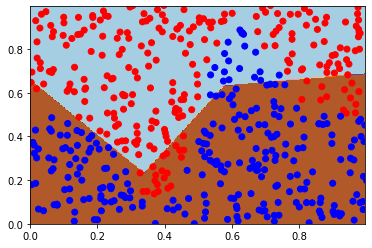

Epoch: [51/200][0/4]	LR: 0.01	Loss 0.2938 (0.2938)	Train Acc 89.453 (89.453)
 * Train Acc 86.375
Test: [0/2]	Loss 0.2873 (0.2873)	Prec@1 87.109 (87.109)
 * Test Acc 87.000
-----------------------------------------------
Epoch: [52/200][0/4]	LR: 0.01	Loss 0.3515 (0.3515)	Train Acc 85.938 (85.938)
 * Train Acc 88.500
Test: [0/2]	Loss 0.2907 (0.2907)	Prec@1 85.547 (85.547)
 * Test Acc 85.333
-----------------------------------------------
Epoch: [53/200][0/4]	LR: 0.01	Loss 0.2822 (0.2822)	Train Acc 87.891 (87.891)
 * Train Acc 86.500
Test: [0/2]	Loss 0.2838 (0.2838)	Prec@1 87.500 (87.500)
 * Test Acc 88.333
-----------------------------------------------
Epoch: [54/200][0/4]	LR: 0.01	Loss 0.2873 (0.2873)	Train Acc 89.062 (89.062)
 * Train Acc 87.625
Test: [0/2]	Loss 0.2937 (0.2937)	Prec@1 84.766 (84.766)
 * Test Acc 85.000
-----------------------------------------------
Epoch: [55/200][0/4]	LR: 0.01	Loss 0.3431 (0.3431)	Train Acc 85.156 (85.156)
 * Train Acc 85.250
Test: [0/2]	Loss 0.2479

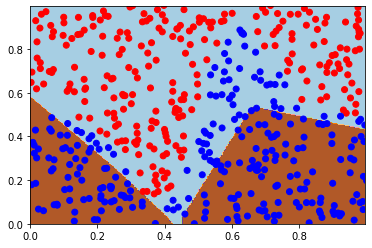

Epoch: [61/200][0/4]	LR: 0.01	Loss 0.2919 (0.2919)	Train Acc 88.281 (88.281)
 * Train Acc 86.500
Test: [0/2]	Loss 0.3293 (0.3293)	Prec@1 83.594 (83.594)
 * Test Acc 83.000
-----------------------------------------------
Epoch: [62/200][0/4]	LR: 0.01	Loss 0.3266 (0.3266)	Train Acc 84.766 (84.766)
 * Train Acc 84.875
Test: [0/2]	Loss 0.2886 (0.2886)	Prec@1 88.672 (88.672)
 * Test Acc 89.000
-----------------------------------------------
Epoch: [63/200][0/4]	LR: 0.01	Loss 0.2612 (0.2612)	Train Acc 88.672 (88.672)
 * Train Acc 86.625
Test: [0/2]	Loss 0.3383 (0.3383)	Prec@1 82.031 (82.031)
 * Test Acc 83.000
-----------------------------------------------
Epoch: [64/200][0/4]	LR: 0.01	Loss 0.3040 (0.3040)	Train Acc 83.594 (83.594)
 * Train Acc 82.750
Test: [0/2]	Loss 0.2151 (0.2151)	Prec@1 94.141 (94.141)
 * Test Acc 92.667
-----------------------------------------------
Epoch: [65/200][0/4]	LR: 0.01	Loss 0.2487 (0.2487)	Train Acc 90.234 (90.234)
 * Train Acc 86.625
Test: [0/2]	Loss 0.2291

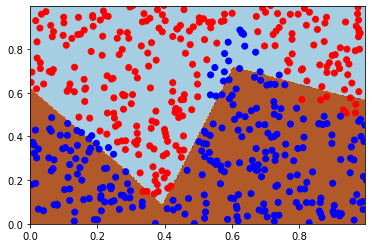

Epoch: [71/200][0/4]	LR: 0.01	Loss 0.2492 (0.2492)	Train Acc 92.188 (92.188)
 * Train Acc 90.750
Test: [0/2]	Loss 0.2289 (0.2289)	Prec@1 91.016 (91.016)
 * Test Acc 91.333
-----------------------------------------------
Epoch: [72/200][0/4]	LR: 0.01	Loss 0.2870 (0.2870)	Train Acc 87.109 (87.109)
 * Train Acc 90.125
Test: [0/2]	Loss 0.2240 (0.2240)	Prec@1 91.797 (91.797)
 * Test Acc 91.667
-----------------------------------------------
Epoch: [73/200][0/4]	LR: 0.01	Loss 0.2457 (0.2457)	Train Acc 91.406 (91.406)
 * Train Acc 90.250
Test: [0/2]	Loss 0.2154 (0.2154)	Prec@1 91.016 (91.016)
 * Test Acc 91.000
-----------------------------------------------
Epoch: [74/200][0/4]	LR: 0.01	Loss 0.2556 (0.2556)	Train Acc 92.188 (92.188)
 * Train Acc 90.250
Test: [0/2]	Loss 0.2240 (0.2240)	Prec@1 90.625 (90.625)
 * Test Acc 90.667
-----------------------------------------------
Epoch: [75/200][0/4]	LR: 0.01	Loss 0.2164 (0.2164)	Train Acc 91.797 (91.797)
 * Train Acc 89.000
Test: [0/2]	Loss 0.2050

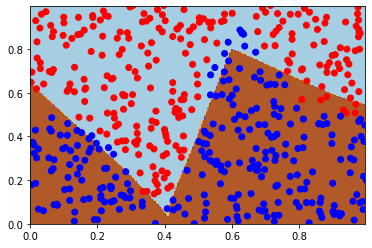

Epoch: [81/200][0/4]	LR: 0.01	Loss 0.2172 (0.2172)	Train Acc 90.234 (90.234)
 * Train Acc 91.625
Test: [0/2]	Loss 0.2306 (0.2306)	Prec@1 91.016 (91.016)
 * Test Acc 92.000
-----------------------------------------------
Epoch: [82/200][0/4]	LR: 0.01	Loss 0.2229 (0.2229)	Train Acc 91.797 (91.797)
 * Train Acc 92.000
Test: [0/2]	Loss 0.2134 (0.2134)	Prec@1 92.578 (92.578)
 * Test Acc 93.000
-----------------------------------------------
Epoch: [83/200][0/4]	LR: 0.01	Loss 0.2268 (0.2268)	Train Acc 91.797 (91.797)
 * Train Acc 91.250
Test: [0/2]	Loss 0.1930 (0.1930)	Prec@1 93.750 (93.750)
 * Test Acc 93.667
-----------------------------------------------
Epoch: [84/200][0/4]	LR: 0.01	Loss 0.2506 (0.2506)	Train Acc 91.016 (91.016)
 * Train Acc 93.000
Test: [0/2]	Loss 0.1822 (0.1822)	Prec@1 94.531 (94.531)
 * Test Acc 94.000
-----------------------------------------------
Epoch: [85/200][0/4]	LR: 0.01	Loss 0.2168 (0.2168)	Train Acc 94.531 (94.531)
 * Train Acc 93.750
Test: [0/2]	Loss 0.2086

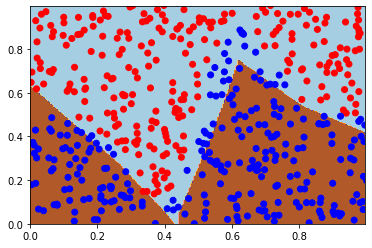

Epoch: [91/200][0/4]	LR: 0.01	Loss 0.2217 (0.2217)	Train Acc 90.234 (90.234)
 * Train Acc 91.500
Test: [0/2]	Loss 0.2251 (0.2251)	Prec@1 90.625 (90.625)
 * Test Acc 91.000
-----------------------------------------------
Epoch: [92/200][0/4]	LR: 0.01	Loss 0.2443 (0.2443)	Train Acc 92.578 (92.578)
 * Train Acc 92.250
Test: [0/2]	Loss 0.1795 (0.1795)	Prec@1 93.359 (93.359)
 * Test Acc 93.333
-----------------------------------------------
Epoch: [93/200][0/4]	LR: 0.01	Loss 0.2154 (0.2154)	Train Acc 92.188 (92.188)
 * Train Acc 93.250
Test: [0/2]	Loss 0.1688 (0.1688)	Prec@1 94.141 (94.141)
 * Test Acc 94.000
-----------------------------------------------
Epoch: [94/200][0/4]	LR: 0.01	Loss 0.2387 (0.2387)	Train Acc 92.969 (92.969)
 * Train Acc 92.500
Test: [0/2]	Loss 0.1984 (0.1984)	Prec@1 92.188 (92.188)
 * Test Acc 92.333
-----------------------------------------------
Epoch: [95/200][0/4]	LR: 0.01	Loss 0.2048 (0.2048)	Train Acc 93.750 (93.750)
 * Train Acc 91.750
Test: [0/2]	Loss 0.1608

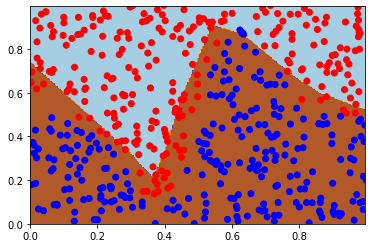

Epoch: [101/200][0/4]	LR: 0.01	Loss 0.2988 (0.2988)	Train Acc 84.766 (84.766)
 * Train Acc 89.375
Test: [0/2]	Loss 0.1627 (0.1627)	Prec@1 93.359 (93.359)
 * Test Acc 93.333
-----------------------------------------------
Epoch: [102/200][0/4]	LR: 0.01	Loss 0.2088 (0.2088)	Train Acc 92.969 (92.969)
 * Train Acc 93.125
Test: [0/2]	Loss 0.2302 (0.2302)	Prec@1 87.500 (87.500)
 * Test Acc 88.000
-----------------------------------------------
Epoch: [103/200][0/4]	LR: 0.01	Loss 0.2866 (0.2866)	Train Acc 89.844 (89.844)
 * Train Acc 91.750
Test: [0/2]	Loss 0.1699 (0.1699)	Prec@1 94.531 (94.531)
 * Test Acc 95.333
-----------------------------------------------
Epoch: [104/200][0/4]	LR: 0.01	Loss 0.2062 (0.2062)	Train Acc 93.750 (93.750)
 * Train Acc 93.875
Test: [0/2]	Loss 0.1801 (0.1801)	Prec@1 94.922 (94.922)
 * Test Acc 95.667
-----------------------------------------------
Epoch: [105/200][0/4]	LR: 0.01	Loss 0.2158 (0.2158)	Train Acc 95.312 (95.312)
 * Train Acc 93.000
Test: [0/2]	Loss 0

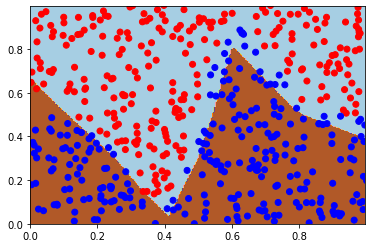

Epoch: [111/200][0/4]	LR: 0.01	Loss 0.2750 (0.2750)	Train Acc 89.453 (89.453)
 * Train Acc 90.750
Test: [0/2]	Loss 0.2295 (0.2295)	Prec@1 91.016 (91.016)
 * Test Acc 91.333
-----------------------------------------------
Epoch: [112/200][0/4]	LR: 0.01	Loss 0.2518 (0.2518)	Train Acc 91.016 (91.016)
 * Train Acc 91.375
Test: [0/2]	Loss 0.2077 (0.2077)	Prec@1 91.406 (91.406)
 * Test Acc 92.667
-----------------------------------------------
Epoch: [113/200][0/4]	LR: 0.01	Loss 0.3557 (0.3557)	Train Acc 86.328 (86.328)
 * Train Acc 90.375
Test: [0/2]	Loss 0.1882 (0.1882)	Prec@1 91.406 (91.406)
 * Test Acc 91.667
-----------------------------------------------
Epoch: [114/200][0/4]	LR: 0.01	Loss 0.2188 (0.2188)	Train Acc 94.141 (94.141)
 * Train Acc 92.500
Test: [0/2]	Loss 0.1672 (0.1672)	Prec@1 94.531 (94.531)
 * Test Acc 95.000
-----------------------------------------------
Epoch: [115/200][0/4]	LR: 0.01	Loss 0.2274 (0.2274)	Train Acc 91.797 (91.797)
 * Train Acc 94.000
Test: [0/2]	Loss 0

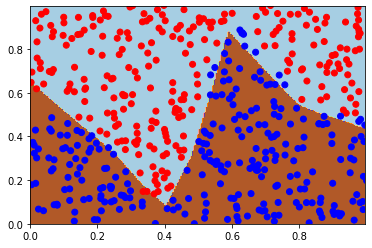

Epoch: [121/200][0/4]	LR: 0.01	Loss 0.2068 (0.2068)	Train Acc 93.359 (93.359)
 * Train Acc 94.250
Test: [0/2]	Loss 0.1599 (0.1599)	Prec@1 94.922 (94.922)
 * Test Acc 94.667
-----------------------------------------------
Epoch: [122/200][0/4]	LR: 0.01	Loss 0.2036 (0.2036)	Train Acc 94.922 (94.922)
 * Train Acc 94.000
Test: [0/2]	Loss 0.1412 (0.1412)	Prec@1 95.703 (95.703)
 * Test Acc 95.000
-----------------------------------------------
Epoch: [123/200][0/4]	LR: 0.01	Loss 0.2096 (0.2096)	Train Acc 94.922 (94.922)
 * Train Acc 95.250
Test: [0/2]	Loss 0.1658 (0.1658)	Prec@1 96.094 (96.094)
 * Test Acc 96.667
-----------------------------------------------
Epoch: [124/200][0/4]	LR: 0.01	Loss 0.1898 (0.1898)	Train Acc 93.359 (93.359)
 * Train Acc 93.625
Test: [0/2]	Loss 0.1586 (0.1586)	Prec@1 94.922 (94.922)
 * Test Acc 95.333
-----------------------------------------------
Epoch: [125/200][0/4]	LR: 0.01	Loss 0.1836 (0.1836)	Train Acc 95.703 (95.703)
 * Train Acc 94.625
Test: [0/2]	Loss 0

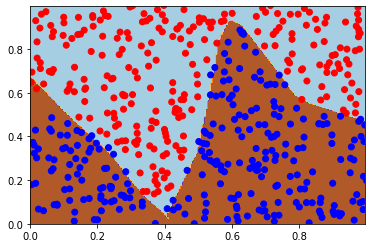

Epoch: [131/200][0/4]	LR: 0.01	Loss 0.1785 (0.1785)	Train Acc 95.703 (95.703)
 * Train Acc 92.875
Test: [0/2]	Loss 0.2132 (0.2132)	Prec@1 90.625 (90.625)
 * Test Acc 91.667
-----------------------------------------------
Epoch: [132/200][0/4]	LR: 0.01	Loss 0.1861 (0.1861)	Train Acc 94.141 (94.141)
 * Train Acc 92.375
Test: [0/2]	Loss 0.1684 (0.1684)	Prec@1 92.578 (92.578)
 * Test Acc 92.333
-----------------------------------------------
Epoch: [133/200][0/4]	LR: 0.01	Loss 0.1775 (0.1775)	Train Acc 92.188 (92.188)
 * Train Acc 91.250
Test: [0/2]	Loss 0.2097 (0.2097)	Prec@1 90.234 (90.234)
 * Test Acc 90.667
-----------------------------------------------
Epoch: [134/200][0/4]	LR: 0.01	Loss 0.2027 (0.2027)	Train Acc 92.188 (92.188)
 * Train Acc 93.000
Test: [0/2]	Loss 0.1404 (0.1404)	Prec@1 96.875 (96.875)
 * Test Acc 97.000
-----------------------------------------------
Epoch: [135/200][0/4]	LR: 0.01	Loss 0.2530 (0.2530)	Train Acc 91.797 (91.797)
 * Train Acc 94.000
Test: [0/2]	Loss 0

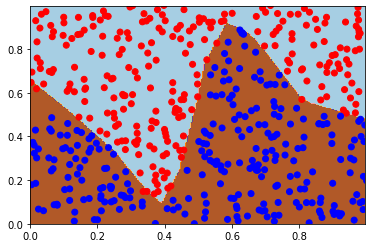

Epoch: [141/200][0/4]	LR: 0.01	Loss 0.2223 (0.2223)	Train Acc 95.312 (95.312)
 * Train Acc 94.500
Test: [0/2]	Loss 0.1405 (0.1405)	Prec@1 95.312 (95.312)
 * Test Acc 95.333
-----------------------------------------------
Epoch: [142/200][0/4]	LR: 0.01	Loss 0.2422 (0.2422)	Train Acc 90.625 (90.625)
 * Train Acc 94.000
Test: [0/2]	Loss 0.1619 (0.1619)	Prec@1 94.531 (94.531)
 * Test Acc 95.333
-----------------------------------------------
Epoch: [143/200][0/4]	LR: 0.01	Loss 0.1492 (0.1492)	Train Acc 95.312 (95.312)
 * Train Acc 94.625
Test: [0/2]	Loss 0.1502 (0.1502)	Prec@1 95.312 (95.312)
 * Test Acc 95.333
-----------------------------------------------
Epoch: [144/200][0/4]	LR: 0.01	Loss 0.2026 (0.2026)	Train Acc 94.922 (94.922)
 * Train Acc 94.875
Test: [0/2]	Loss 0.1336 (0.1336)	Prec@1 96.484 (96.484)
 * Test Acc 96.667
-----------------------------------------------
Epoch: [145/200][0/4]	LR: 0.01	Loss 0.1880 (0.1880)	Train Acc 95.703 (95.703)
 * Train Acc 95.750
Test: [0/2]	Loss 0

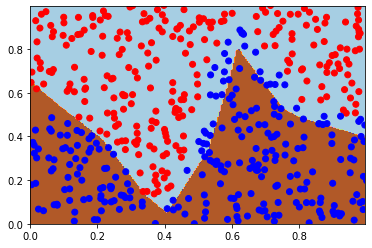

Epoch: [151/200][0/4]	LR: 0.01	Loss 0.1986 (0.1986)	Train Acc 91.797 (91.797)
 * Train Acc 90.875
Test: [0/2]	Loss 0.2326 (0.2326)	Prec@1 88.672 (88.672)
 * Test Acc 88.000
-----------------------------------------------
Epoch: [152/200][0/4]	LR: 0.01	Loss 0.2126 (0.2126)	Train Acc 92.969 (92.969)
 * Train Acc 92.250
Test: [0/2]	Loss 0.1944 (0.1944)	Prec@1 91.797 (91.797)
 * Test Acc 91.667
-----------------------------------------------
Epoch: [153/200][0/4]	LR: 0.01	Loss 0.1992 (0.1992)	Train Acc 89.844 (89.844)
 * Train Acc 89.500
Test: [0/2]	Loss 0.2632 (0.2632)	Prec@1 85.547 (85.547)
 * Test Acc 86.667
-----------------------------------------------
Epoch: [154/200][0/4]	LR: 0.01	Loss 0.2595 (0.2595)	Train Acc 90.234 (90.234)
 * Train Acc 91.500
Test: [0/2]	Loss 0.2053 (0.2053)	Prec@1 92.188 (92.188)
 * Test Acc 92.667
-----------------------------------------------
Epoch: [155/200][0/4]	LR: 0.01	Loss 0.2953 (0.2953)	Train Acc 87.500 (87.500)
 * Train Acc 90.750
Test: [0/2]	Loss 0

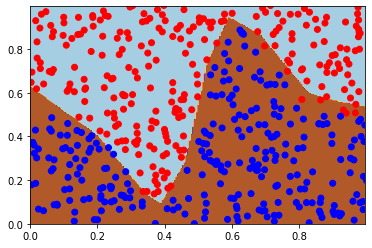

Epoch: [161/200][0/4]	LR: 0.01	Loss 0.1225 (0.1225)	Train Acc 97.656 (97.656)
 * Train Acc 93.875
Test: [0/2]	Loss 0.1374 (0.1374)	Prec@1 94.141 (94.141)
 * Test Acc 94.000
-----------------------------------------------
Epoch: [162/200][0/4]	LR: 0.01	Loss 0.1622 (0.1622)	Train Acc 94.531 (94.531)
 * Train Acc 93.375
Test: [0/2]	Loss 0.1734 (0.1734)	Prec@1 96.094 (96.094)
 * Test Acc 96.000
-----------------------------------------------
Epoch: [163/200][0/4]	LR: 0.01	Loss 0.2060 (0.2060)	Train Acc 92.578 (92.578)
 * Train Acc 93.000
Test: [0/2]	Loss 0.1490 (0.1490)	Prec@1 92.578 (92.578)
 * Test Acc 93.333
-----------------------------------------------
Epoch: [164/200][0/4]	LR: 0.01	Loss 0.1429 (0.1429)	Train Acc 93.359 (93.359)
 * Train Acc 93.250
Test: [0/2]	Loss 0.1589 (0.1589)	Prec@1 93.750 (93.750)
 * Test Acc 94.000
-----------------------------------------------
Epoch: [165/200][0/4]	LR: 0.01	Loss 0.1846 (0.1846)	Train Acc 95.703 (95.703)
 * Train Acc 95.250
Test: [0/2]	Loss 0

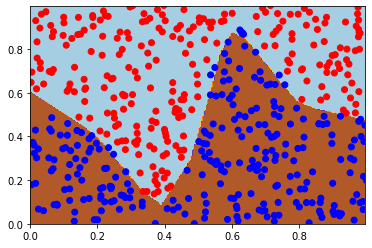

Epoch: [171/200][0/4]	LR: 0.01	Loss 0.1604 (0.1604)	Train Acc 93.750 (93.750)
 * Train Acc 94.500
Test: [0/2]	Loss 0.1302 (0.1302)	Prec@1 95.703 (95.703)
 * Test Acc 96.000
-----------------------------------------------
Epoch: [172/200][0/4]	LR: 0.01	Loss 0.2062 (0.2062)	Train Acc 95.703 (95.703)
 * Train Acc 96.125
Test: [0/2]	Loss 0.1355 (0.1355)	Prec@1 93.750 (93.750)
 * Test Acc 94.000
-----------------------------------------------
Epoch: [173/200][0/4]	LR: 0.01	Loss 0.1752 (0.1752)	Train Acc 92.969 (92.969)
 * Train Acc 93.750
Test: [0/2]	Loss 0.1483 (0.1483)	Prec@1 95.703 (95.703)
 * Test Acc 95.000
-----------------------------------------------
Epoch: [174/200][0/4]	LR: 0.01	Loss 0.1997 (0.1997)	Train Acc 94.531 (94.531)
 * Train Acc 94.750
Test: [0/2]	Loss 0.1297 (0.1297)	Prec@1 94.922 (94.922)
 * Test Acc 95.000
-----------------------------------------------
Epoch: [175/200][0/4]	LR: 0.01	Loss 0.2331 (0.2331)	Train Acc 92.188 (92.188)
 * Train Acc 94.625
Test: [0/2]	Loss 0

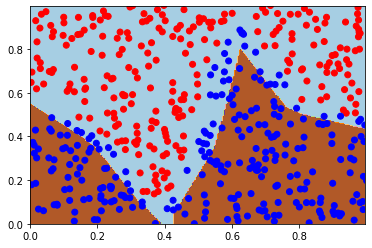

Epoch: [181/200][0/4]	LR: 0.01	Loss 0.2386 (0.2386)	Train Acc 88.281 (88.281)
 * Train Acc 91.125
Test: [0/2]	Loss 0.2499 (0.2499)	Prec@1 86.719 (86.719)
 * Test Acc 87.000
-----------------------------------------------
Epoch: [182/200][0/4]	LR: 0.01	Loss 0.2768 (0.2768)	Train Acc 87.109 (87.109)
 * Train Acc 91.125
Test: [0/2]	Loss 0.1734 (0.1734)	Prec@1 92.188 (92.188)
 * Test Acc 92.333
-----------------------------------------------
Epoch: [183/200][0/4]	LR: 0.01	Loss 0.2380 (0.2380)	Train Acc 91.016 (91.016)
 * Train Acc 90.250
Test: [0/2]	Loss 0.1723 (0.1723)	Prec@1 94.141 (94.141)
 * Test Acc 93.667
-----------------------------------------------
Epoch: [184/200][0/4]	LR: 0.01	Loss 0.2219 (0.2219)	Train Acc 92.578 (92.578)
 * Train Acc 94.625
Test: [0/2]	Loss 0.1438 (0.1438)	Prec@1 94.531 (94.531)
 * Test Acc 93.667
-----------------------------------------------
Epoch: [185/200][0/4]	LR: 0.01	Loss 0.1809 (0.1809)	Train Acc 92.969 (92.969)
 * Train Acc 91.125
Test: [0/2]	Loss 0

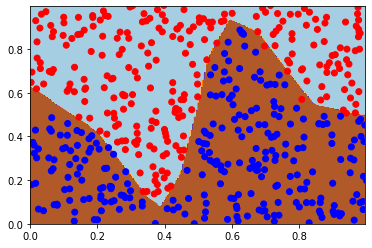

Epoch: [191/200][0/4]	LR: 0.01	Loss 0.1517 (0.1517)	Train Acc 96.094 (96.094)
 * Train Acc 96.250
Test: [0/2]	Loss 0.1312 (0.1312)	Prec@1 94.531 (94.531)
 * Test Acc 94.667
-----------------------------------------------
Epoch: [192/200][0/4]	LR: 0.01	Loss 0.1806 (0.1806)	Train Acc 93.750 (93.750)
 * Train Acc 94.500
Test: [0/2]	Loss 0.1349 (0.1349)	Prec@1 96.094 (96.094)
 * Test Acc 96.000
-----------------------------------------------
Epoch: [193/200][0/4]	LR: 0.01	Loss 0.1529 (0.1529)	Train Acc 95.703 (95.703)
 * Train Acc 94.750
Test: [0/2]	Loss 0.1190 (0.1190)	Prec@1 96.094 (96.094)
 * Test Acc 95.667
-----------------------------------------------
Epoch: [194/200][0/4]	LR: 0.01	Loss 0.1695 (0.1695)	Train Acc 94.922 (94.922)
 * Train Acc 95.750
Test: [0/2]	Loss 0.1286 (0.1286)	Prec@1 96.875 (96.875)
 * Test Acc 97.000
-----------------------------------------------
Epoch: [195/200][0/4]	LR: 0.01	Loss 0.1643 (0.1643)	Train Acc 97.266 (97.266)
 * Train Acc 95.375
Test: [0/2]	Loss 0

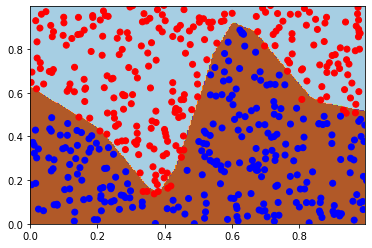

In [13]:
best_prec1 = 0
for epoch in range(num_epochs):
    if epoch in lr_step:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1

    # train for one epoch
    train(train_loader, model, criterion, optimizer, epoch)

    # evaluate on validation set
    # prec1 = 0
    prec1 = validate(val_loader, model, criterion)

    # remember best prec@1 and save checkpoint
    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_prec1': best_prec1,
        'optimizer': optimizer.state_dict(),
    }, is_best,filename="checkpoint.pth.tar")
    print("-----------------------------------------------")
    
    if epoch%print_freq==0:
        plot_decision_boundary(model)

plot_decision_boundary(model)

## (a) Plot how the training loss changes with epochs. Also, plot the training accuracy and validation accuracy in a single plot. Comment on the trends.


In [109]:
def train_loss(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        target = target.to(device)
        input_var = torch.autograd.Variable(input).to(device)
        target_var = torch.autograd.Variable(target).to(device)
        # target_var = torch.squeeze(target_var)
        # compute output
        output = model(input_var)
        
        # compute loss
        loss = criterion(output, target_var.long())

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)
        losses.update(loss.item(), input.size(0))
        top1.update(prec1[0][0], input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

#     if i % print_freq == 0:
#         curr_lr = optimizer.param_groups[0]['lr']
#         print('Epoch: [{0}/{1}][{2}/{3}]\t'
#               'LR: {4}\t'
#               'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
#               'Train Acc {top1.val:.3f} ({top1.avg:.3f})'.format(
#                epoch, num_epochs, i, len(train_loader), curr_lr,
#                loss=losses, top1=top1))


    return losses.avg, top1.avg
    #print(' * Train Acc {top1.avg:.3f}'.format(top1=top1))
    
    
    

In [110]:
def validate_a(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        target = target.to(device)
        input_var = torch.autograd.Variable(input, volatile=True).to(device)
        target_var = torch.autograd.Variable(target, volatile=True).to(device)

        # compute output
        output = model(input_var)
        # loss = criterion(output, target_var[:,None])
        loss = criterion(output, target_var.long())
        
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)
        losses.update(loss.item(), input.size(0))
        top1.update(prec1[0][0], input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()


    return top1.avg

In [111]:
torch.manual_seed(999)
model1 = linear_nn(num_neurons,activations).to(device)

# define loss function (criterion) and optimizer
# criterion = nn.BCEWithLogitsLoss().to(device) 
criterion = nn.CrossEntropyLoss().to(device)

optimizer1 = torch.optim.Adam(model1.parameters(),lr=lr, weight_decay=weight_decay)


In [112]:
#Plot how the training loss changes with epochs.
#Also, plot the training accuracy and validation accuracy in a single plot. Comment on the trends.
loss_val = []
acc_val = []
val_val = []
for epoch in range(200):
    loss_a, acc_a = train_loss(train_loader, model1, criterion, optimizer1, epoch+1)
    loss_val.append(loss_a)
    acc_val.append(acc_a)
    validate_acc = validate_a(val_loader, model1, criterion)
    val_val.append(validate_acc)
#loss_val,acc_val,val_val

<ipython-input-110-d232a696243f>:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_var = torch.autograd.Variable(input, volatile=True).to(device)
<ipython-input-110-d232a696243f>:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  target_var = torch.autograd.Variable(target, volatile=True).to(device)


Text(0.5, 1.0, 'loss rate')

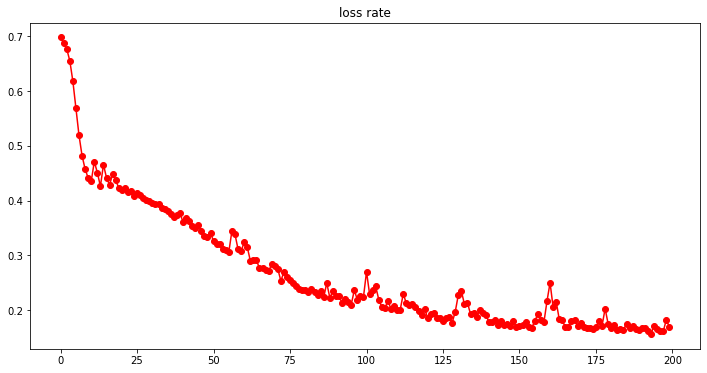

In [113]:
import numpy as np
x=np.arange(200)
fig = plt.figure(figsize=(12, 6))
plt.plot(x, loss_val, '-ok', color='red')
plt.title('loss rate')

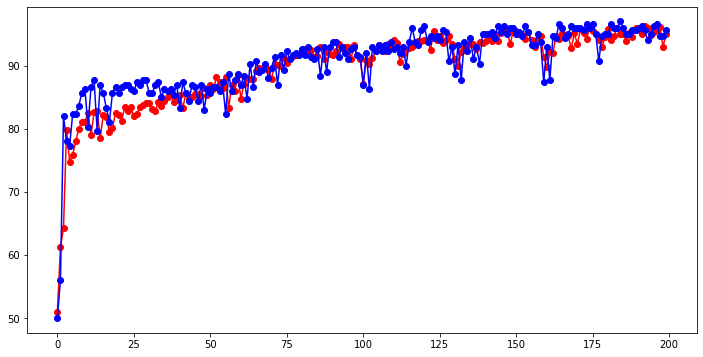

In [19]:
import numpy as np
x=np.arange(200)
fig = plt.figure(figsize=(12, 6))
plt.plot(x, acc_val,'-ok', color='red')
plt.plot(x, val_val,'-ok', color='blue')

## b) Effect of learning rate: run the code with lr = [1, 0.1,0.01,0.001,0.0001]. Plot the training and validation accuracy for each of these learning rates. Comment on which learning rate is best and what is the issue with other learning rates.

In [84]:
lr = [1, 0.1,0.01,0.001,0.0001]

acc_final=[]
val_final=[]
for rate in lr:
    acc_val_b = []
    val_val_b = []

    model2 = linear_nn(num_neurons,activations).to(device)
    optimizer2 = torch.optim.Adam(model2.parameters(),lr=rate,weight_decay=weight_decay)

    for epoch in range(200):
        acc_b = train_loss(train_loader, model2, criterion, optimizer2, epoch+1)[1]
        validate_b = validate_a(val_loader, model2, criterion)
        acc_val_b.append(acc_b)
        val_val_b.append(validate_b)
    acc_final.append(acc_val_b)
    val_final.append(val_val_b)


<ipython-input-15-d232a696243f>:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_var = torch.autograd.Variable(input, volatile=True).to(device)
<ipython-input-15-d232a696243f>:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  target_var = torch.autograd.Variable(target, volatile=True).to(device)


Text(0.5, 1.0, 'lr accuracy rate')

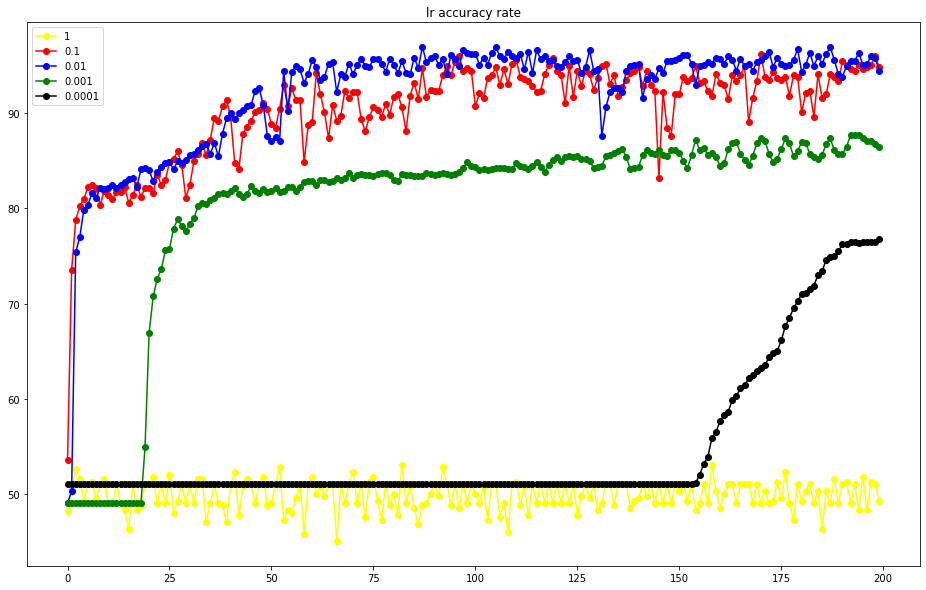

In [114]:
import numpy as np

fig=plt.figure(figsize=(16, 10))
x=np.arange(200)
plt.plot(x, acc_final[0],'-ok', color='yellow', label='1')
plt.plot(x, acc_final[1],'-ok', color='red',label='0.1')
plt.plot(x, acc_final[2],'-ok', color='blue',label='0.01')
plt.plot(x, acc_final[3],'-ok', color='green',label='0.001')
plt.plot(x, acc_final[4],'-ok', color='black',label='0.0001')
plt.legend()

plt.title('lr accuracy rate')

Text(0.5, 1.0, 'lr validation rate')

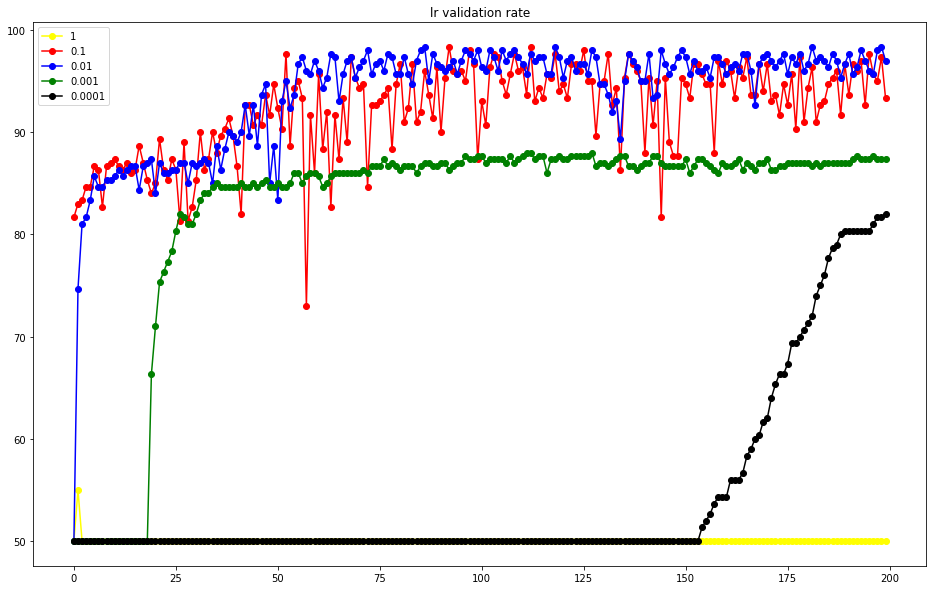

In [115]:

fig=plt.figure(figsize=(16, 10))
x=np.arange(200)
plt.plot(x, val_final[0],'-ok', color='yellow', label='1')
plt.plot(x, val_final[1],'-ok', color='red',label='0.1')
plt.plot(x, val_final[2],'-ok', color='blue',label='0.01')
plt.plot(x, val_final[3],'-ok', color='green',label='0.001')
plt.plot(x, val_final[4],'-ok', color='black',label='0.0001')
plt.legend()

plt.title('lr validation rate')

## As looking at both accuracy and validation rate charts, the lr =0.01 shows the best result as the line are less valitale and give a high accurcry rate.
## when lr =1, the step is too large, where it doesnt convex, and when the lr =0.0001, the step is too small and it stayed at the same accuracy rate till later on at around 150th epoch it start to convex. For lr 0.001 is too flat and accuracy rate is not high compare to other lr. for lr =0.1, it has a high accuracy and validation rate but it's valitale and rates goes up and down.  So overall r=0.01 provide the best result. 

## c 
The current model uses 3 hidden layers with 20, 10, and 10 neurons in the first, second, and third hidden layers respectively. Now, keeping the remaining parameters the same, change this to a model with 1 hidden layer containing 100 neurons. Report the final training and testing accuracies for both the models. Also, report the number of network parameters for these models. Comment on which model is the best. Is the deep network better or the shallow one?

In [ ]:
num_neurons = [2,100,2] 


loss_val_c = []
acc_val_c = []
val_val_c = []
model3 = linear_nn(num_neurons,activations).to(device)
optimizer3 = torch.optim.Adam(model3.parameters(),lr=lr,weight_decay=weight_decay)

for epoch in range(200):
    loss_c, acc_c = train_loss(train_loader, model3, criterion, optimizer3, epoch+1)
    loss_val.append(loss_c)
    acc_val.append(acc_c)
    validate_acc = validate_c(val_loader, model1, criterion)
    val_val_c.append(validate_acc)

Text(0.5, 1.0, 'layer compare')

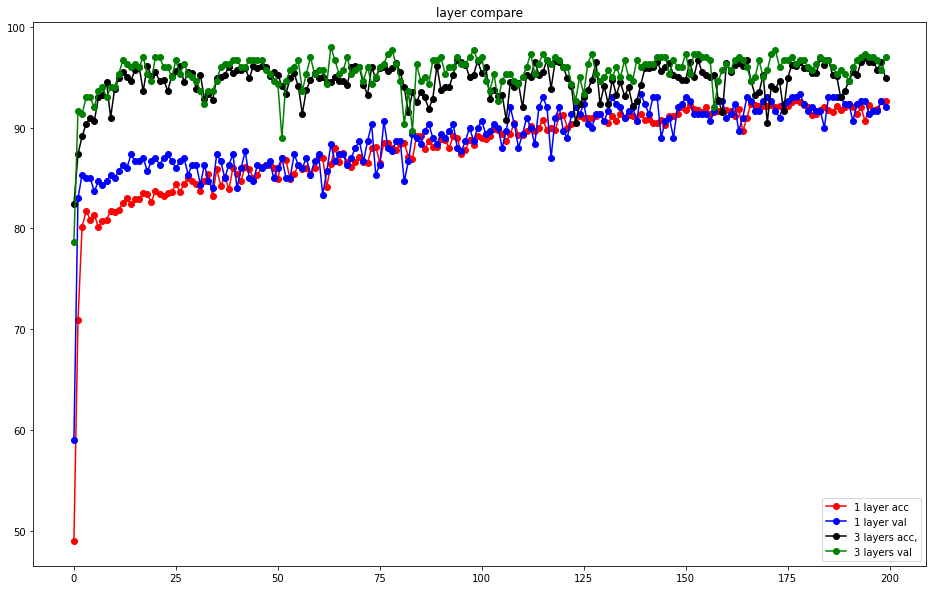

In [103]:
x=np.arange(200)
fig = plt.figure(figsize=(16, 10))
plt.plot(x, acc_val_c,'-ok', color='red', label='1 layer acc')
plt.plot(x, val_val_c,'-ok', color='blue',label='1 layer val')
plt.plot(x, acc_val,'-ok', color='black',label='3 layers acc,')
plt.plot(x, val_val,'-ok', color='green', label='3 layers val')
plt.legend()
plt.title('layer compare')

## the 3 layers are doing better compare to 1 layer as you can see the accuracy rate showing on the chart above.  The number of paramters for this one is 502 with n=100.
2x100 + 100x2 + 100 +2=502. 

502